In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Визначення пристрою
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Клас Dataset
class BrainCTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Завантаження збереженої моделі
def load_model(model_path):
    model = models.resnet18(pretrained=False)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 3)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

# Трансформації
val_transform = transforms.Compose([
    transforms.Normalize(mean=[0.485], std=[0.229])
])


# Шляхи до даних
test_path = "Brain_Stroke_CT_Dataset/External_Test/PNG"
test_labels_path = "Brain_Stroke_CT_Dataset/External_Test/labels.csv"
model_path = "best_model.pth"

# Завантаження моделі
model = load_model(model_path)

# Завантаження міток
df_labels = pd.read_csv(test_labels_path)
df_labels.rename(columns={"Stroke": "True_Label"}, inplace=True)

# Завантаження та обробка зображень
test_images = []
test_filenames = []

for img_file in os.listdir(test_path):
    if img_file.endswith('.png'):
        img_path = os.path.join(test_path, img_file)
        image = Image.open(img_path).convert('L')  # Градації сірого
        image = image.resize((224, 224))
        image = np.array(image)
        test_images.append(image)
        test_filenames.append(img_file)

# Конвертація в тензори
test_images = torch.from_numpy(np.array(test_images)).unsqueeze(1).float()

# Створення DataLoader
test_dataset = BrainCTDataset(test_images, torch.zeros(len(test_images)), transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Прогнозування
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())

# Формування результатів
df_results = pd.DataFrame({
    "image_id": [int(fname.split(".")[0]) for fname in test_filenames],
    "Predicted_Label_Multiclass": predictions
})

df_results["Predicted_Label_Binary"] = df_results["Predicted_Label_Multiclass"].apply(
    lambda x: 1 if x in [1, 2] else 0
)

# Об'єднання з реальними мітками
df_comparison = df_labels.merge(df_results, on="image_id", how="inner")

# Обчислення точності
accuracy_binary = (df_comparison["True_Label"] == df_comparison["Predicted_Label_Binary"]).mean() * 100

# Вивід результатів
print("\nПерші 5 результатів:")
print(df_comparison.head())
print(f"\nТочність моделі (бінарна класифікація): {accuracy_binary:.2f}%")

# Збереження результатів
comparison_csv_path = "Brain_Stroke_CT_Dataset/External_Test/comparison.csv"
df_comparison.to_csv(comparison_csv_path, index=False)
print(f"\nРезультати збережено у файл: {comparison_csv_path}")


c:\Users\User\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\miniconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\User\AppData\Local\Temp\ipykernel_2564\333255916.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_


Перші 5 результатів:
   image_id  True_Label  Predicted_Label_Multiclass  Predicted_Label_Binary
0     10189           0                           0                       0
1     10200           0                           0                       0
2     10231           0                           1                       1
3     10267           0                           0                       0
4     10300           0                           0                       0

Точність моделі (бінарна класифікація): 90.00%

Результати збережено у файл: Brain_Stroke_CT_Dataset/External_Test/comparison.csv


In [3]:
from sklearn.metrics import classification_report

print(classification_report(df_comparison['True_Label'], df_comparison['Predicted_Label_Binary']))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       130
           1       0.93      0.77      0.84        70

    accuracy                           0.90       200
   macro avg       0.91      0.87      0.89       200
weighted avg       0.90      0.90      0.90       200



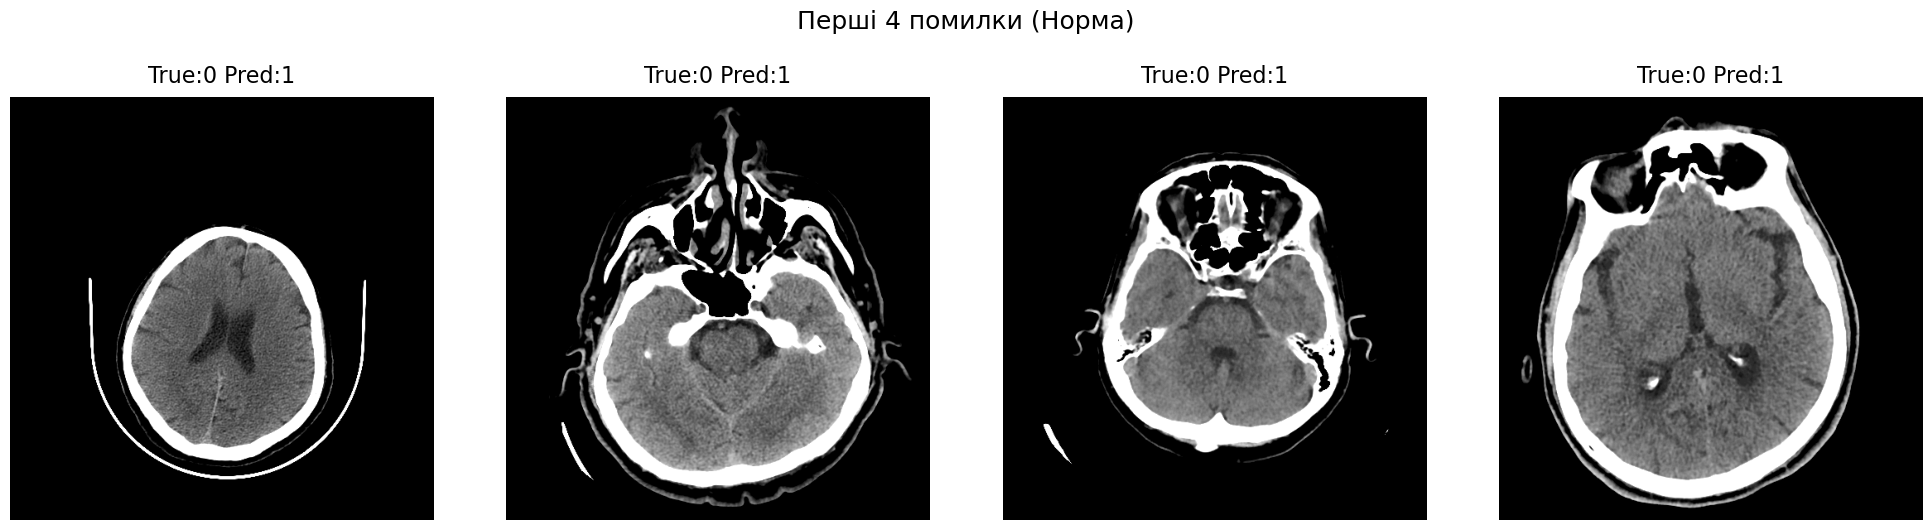

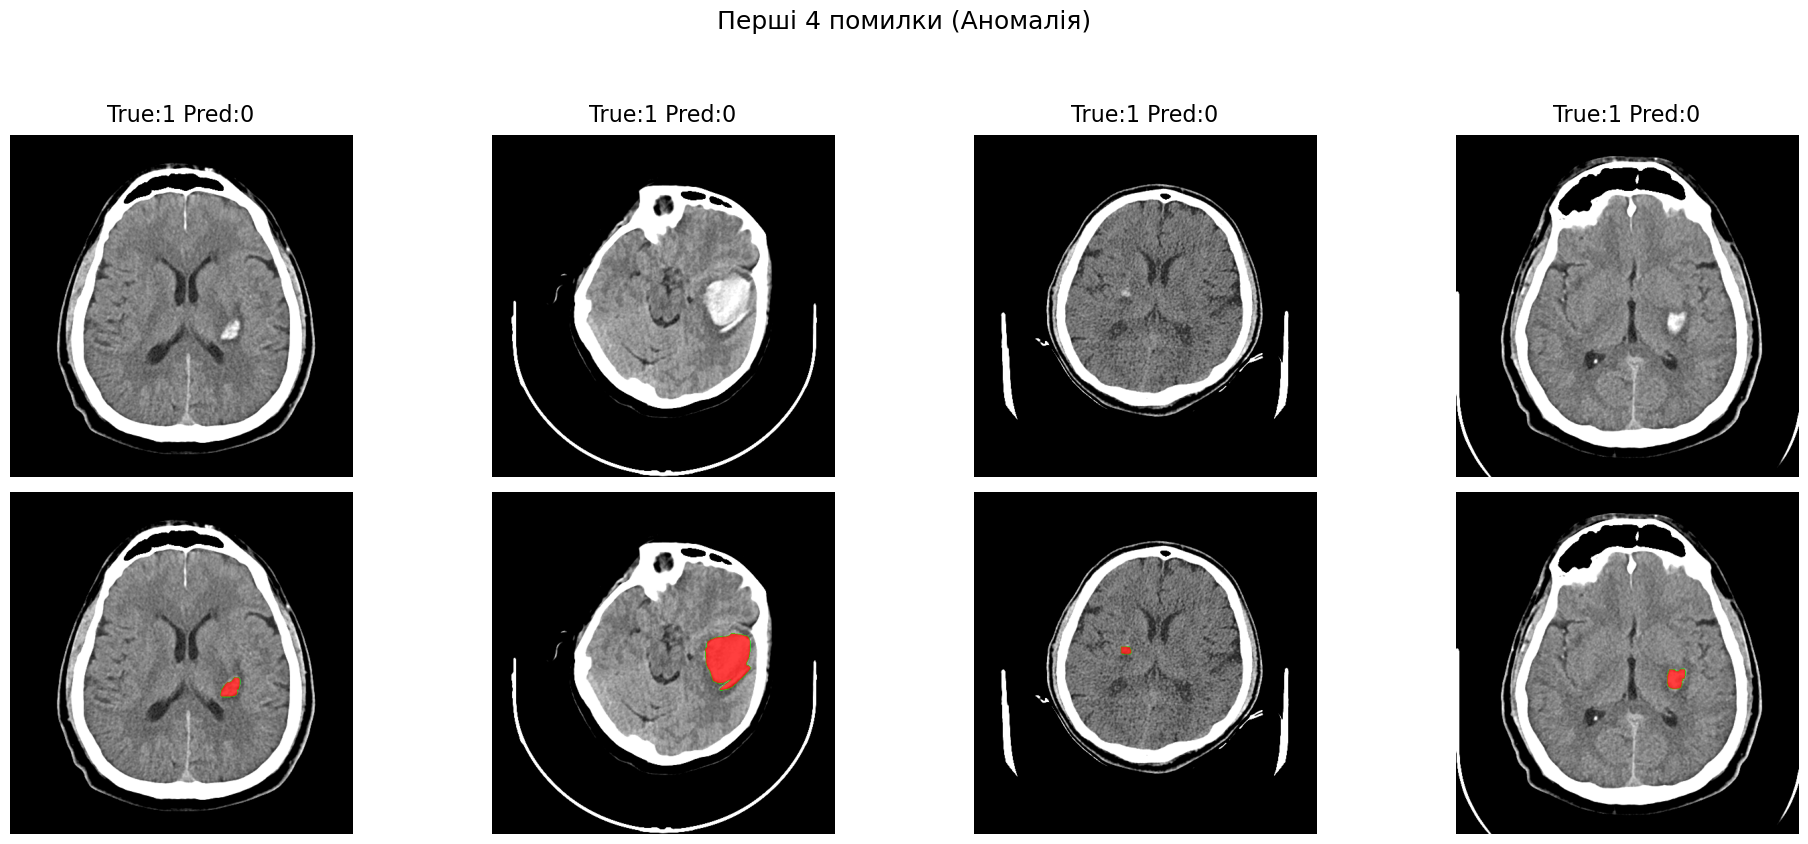

In [29]:
import matplotlib.pyplot as plt
import os

# Шляхи до даних
test_path = os.path.join("Brain_Stroke_CT_Dataset", "External_Test", "PNG")
overlay_path = os.path.join("Brain_Stroke_CT_Dataset", "External_Test", "OVERLAY")

# Визначаємо помилки для кожної категорії
incorrect_normal = df_comparison[
    (df_comparison["True_Label"] == 0) & 
    (df_comparison["Predicted_Label_Binary"] == 1)
].head(4)

incorrect_anomaly = df_comparison[
    (df_comparison["True_Label"] == 1) & 
    (df_comparison["Predicted_Label_Binary"] == 0)
].head(4)

def plot_normal_errors(samples):
    if samples.empty:
        print("Немає помилок класу 'Норма'")
        return
    
    n = min(len(samples), 4)
    fig, axes = plt.subplots(1, n, figsize=(n*5, 5))
    
    if n == 1:
        axes = [axes]
    
    for ax, (_, row) in zip(axes, samples.iterrows()):
        try:
            img = Image.open(os.path.join(test_path, f"{row['image_id']}.png")).convert('L')
            ax.imshow(img, cmap='gray')
            ax.set_title(f"True:{row['True_Label']} Pred:{row['Predicted_Label_Binary']}", 
                        fontsize=16, pad=10)
        except FileNotFoundError:
            ax.text(0.5, 0.5, "No image", ha='center', va='center', fontsize=14)
        
        ax.axis('off')
    
    plt.suptitle("Перші 4 помилки (Норма)", fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()

def plot_anomaly_errors(samples):
    if samples.empty:
        print("Немає помилок класу 'Аномалія'")
        return
    
    n = min(len(samples), 4)
    fig, axes = plt.subplots(2, n, figsize=(n*5, 8))
    
    if n == 1:
        axes = [[axes[0]], [axes[1]]]
    
    for i, (_, row) in enumerate(samples.iterrows()):
        try:
            # Оригінал
            img = Image.open(os.path.join(test_path, f"{row['image_id']}.png")).convert('L')
            axes[0][i].imshow(img, cmap='gray')
            axes[0][i].set_title(f"True:{row['True_Label']} Pred:{row['Predicted_Label_Binary']}", 
                               fontsize=16, pad=10)
            
            # Оверлей
            overlay = Image.open(os.path.join(overlay_path, f"{row['image_id']}.png"))
            axes[1][i].imshow(overlay)
            
        except FileNotFoundError:
            for j in range(2):
                axes[j][i].text(0.5, 0.5, "No image", ha='center', va='center', fontsize=14)
        
        for j in range(2):
            axes[j][i].axis('off')
    
    plt.suptitle("Перші 4 помилки (Аномалія)", fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()

# Виклик функцій
plot_normal_errors(incorrect_normal)
plot_anomaly_errors(incorrect_anomaly)